### A/B Test – Recommendation System Algorithm Update  
#### Exploratory Data Analysis (EDA) 

This notebook explores the cleaned session-level dataset to understand user engagement behavior across control and treatment groups. The objective is to examine metric distributions, validate group comparability, and identify patterns that may influence subsequent statistical testing.

The analysis focuses on descriptive statistics, distributional characteristics, and behavioral trends prior to formal hypothesis testing.

#### 1. Imports and Data Loading

In [1]:
# Import core libraries for analysis and visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Add project root to Python path
import sys
import os

sys.path.append(os.path.abspath(".."))

# Import reusable data loader
from src.data_loader import load_cleaned_data

# Load dataset with enforced schema
df = load_cleaned_data()

#### 2. Dataset Overview

In [3]:
# Preview the first five rows
df.head()

,user_id,group,session_id,session_start,session_end,impressions,clicks,content_started,content_completed,total_watch_time_minutes,device_type,os,app_version,language_preference,referral_source,subscription_type,is_premium_user
0,8116,control,48680,2026-01-11 12:07:36.131448076,2026-01-11 12:52:36.131448076,21,6,4,1,22.08,tablet,Android,5.0.0,Spanish,push_notification,Basic,False
1,12109,control,72536,2026-01-14 10:02:48.687211687,2026-01-14 11:11:48.687211687,24,8,8,2,37.17,smart_tv,Android,Unknown,Turkish,push_notification,Basic,False
2,15861,control,94927,2026-01-14 10:28:05.164624346,2026-01-14 11:59:05.164624346,21,3,3,1,34.53,desktop,iOS,6.0.0,Dutch,ad_campaign,Premium,False
3,21199,treatment,127477,2026-01-03 20:33:22.917005566,2026-01-03 22:06:22.917005566,24,6,6,5,66.34,desktop,Android,6.1.1,German,email,Premium,True
4,2324,control,13847,2026-01-18 05:00:07.290494422,2026-01-18 06:52:07.290494422,15,3,2,1,79.78,mobile,Windows,5.2.1,Spanish,push_notification,Premium,False


In [4]:
# Display dataset dimensions
print(f"Number of rows: {df.shape[0]}")
print(f"Number of columns: {df.shape[1]}")

Number of rows: 147669
Number of columns: 17


In [5]:
# Display column names, data types, and non-null counts
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 147669 entries, 0 to 147668
Data columns (total 17 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   user_id                   147669 non-null  string        
 1   group                     147669 non-null  category      
 2   session_id                147669 non-null  string        
 3   session_start             147669 non-null  datetime64[ns]
 4   session_end               147669 non-null  datetime64[ns]
 5   impressions               147669 non-null  int64         
 6   clicks                    147669 non-null  int64         
 7   content_started           147669 non-null  int64         
 8   content_completed         147669 non-null  int64         
 9   total_watch_time_minutes  147669 non-null  float64       
 10  device_type               147669 non-null  category      
 11  os                        147669 non-null  category      
 12  ap

### 3. Session and User Activity Structure
This section examines the structural characteristics of user activity within the experiment period. The objective is to understand session frequency, session duration, and overall engagement intensity before analyzing experimental metrics.

Understanding baseline behavioral patterns ensures that subsequent engagement comparisons are interpreted within the proper activity context.

#####  3.1. Sessions per User
This subsection examines how frequently users engaged with the platform during the experiment period. Understanding session frequency helps identify whether activity is evenly distributed or dominated by a subset of highly active users.

In [6]:
# Calculate number of sessions per user
sessions_per_user = df.groupby('user_id')['session_id'].count()

# Display descriptive statistics
sessions_per_user.describe()

count    24495.000000
mean         6.028536
std          2.460209
min          1.000000
25%          4.000000
50%          6.000000
75%          8.000000
max         21.000000
Name: session_id, dtype: float64

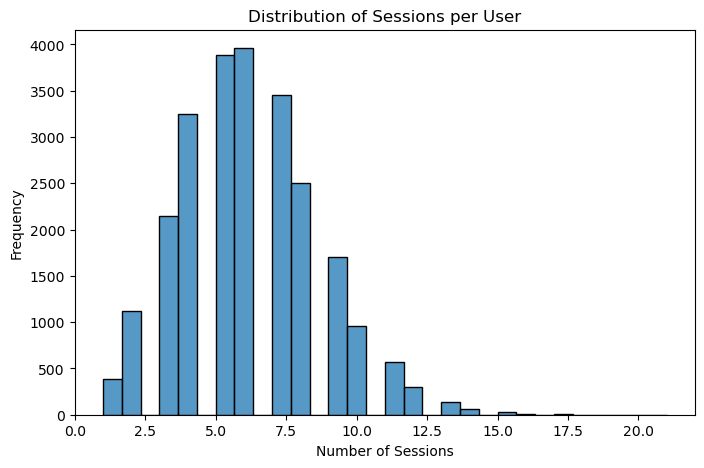

In [7]:
# Plot distribution of sessions per user
plt.figure(figsize=(8,5))
sns.histplot(sessions_per_user, bins=30)
plt.title("Distribution of Sessions per User")
plt.xlabel("Number of Sessions")
plt.ylabel("Frequency")
plt.show()

#####  3.2. Session Duration

In [8]:
# Calculate session duration in minutes
df["session_duration_minutes"] = (
    (df["session_end"] - df["session_start"]).dt.total_seconds() / 60
)

# Display descriptive statistics
df["session_duration_minutes"].describe()

count    147669.000000
mean         64.898557
std          32.022710
min          10.000000
25%          37.000000
50%          65.000000
75%          93.000000
max         120.000000
Name: session_duration_minutes, dtype: float64

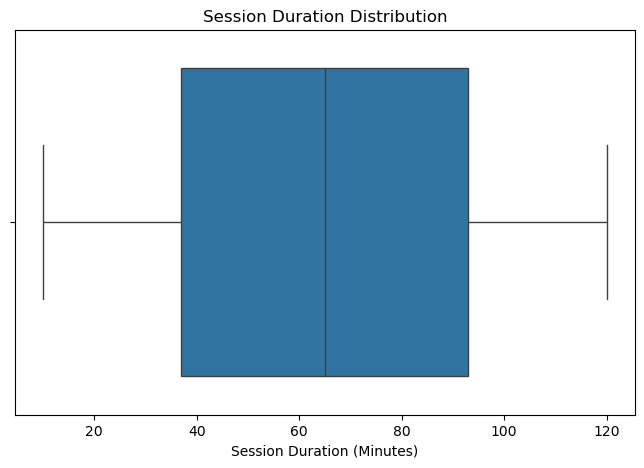

In [9]:
# Visualize distribution of session duration to inspect spread and potential outliers
plt.figure(figsize=(8,5))
sns.boxplot(x=df["session_duration_minutes"])
plt.title("Session Duration Distribution")
plt.xlabel("Session Duration (Minutes)")
plt.show()

#####  3.3. Impressions and Click Volume

In [10]:
# Descriptive statistics for impressions and clicks
df[["impressions","clicks"]].describe()

,impressions,clicks
count,147669.000000,147669.000000
mean,19.984059,3.101314
std,5.023808,1.801089
min,0.000000,0.000000
25%,17.000000,2.000000
50%,20.000000,3.000000
75%,23.000000,4.000000
max,42.000000,14.000000


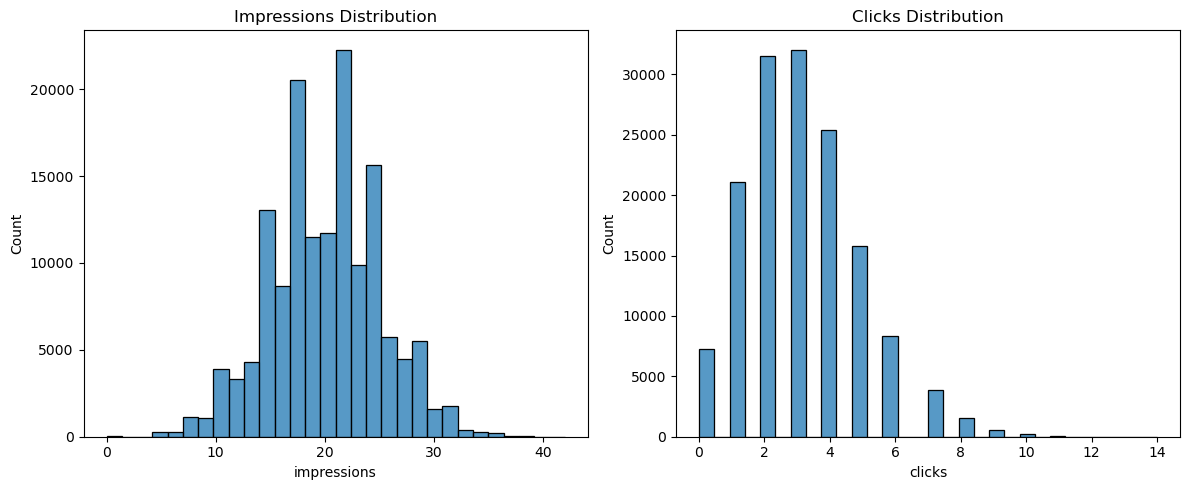

In [11]:
# Compare distributions of impressions and clicks per session
fig, axes = plt.subplots(1, 2, figsize=(12,5))

sns.histplot(df["impressions"], bins=30, ax=axes[0])
axes[0].set_title("Impressions Distribution")

sns.histplot(df["clicks"], bins=30, ax=axes[1])
axes[1].set_title("Clicks Distribution")

plt.tight_layout()
plt.show()

#### Summary of Session and Activity Structure

- Users averaged approximately 6 sessions during the 21-day period; the distribution is mildly right-skewed with a small tail of higher-activity users, but no evidence of heavy-user dominance.

- Session duration is symmetrically distributed, ranging from 10 to 120 minutes, with a median of 65 minutes. The bounded range reflects controlled simulation parameters and avoids unrealistic engagement extremes.

- Recommendation exposure is consistent across sessions, with a median of 20 impressions and 3 clicks per session. Engagement intensity appears proportionate, with no structural violations or extreme interaction values observed.

Overall, baseline user activity demonstrates stable engagement dynamics, providing a reliable foundation for subsequent metric evaluation and experimental comparison.

#### 4. Engagement Metrics Exploration (Session-Level)

##### 4.1. Click-Through Rate (CTR)

This subsection examines the distribution of session-level CTR. CTR is calculated as clicks divided by impressions, with zero-impression sessions handled to avoid division errors.

In [12]:
# Calculate session-level CTR (handle zero impressions) 
df['ctr'] = np.where(
    df["impressions"] > 0,
    df["clicks"] / df["impressions"], 
    0
)

# Display descriptive statistics
df["ctr"].describe()

count    147669.000000
mean          0.155178
std           0.084404
min           0.000000
25%           0.095238
50%           0.150000
75%           0.208333
max           0.714286
Name: ctr, dtype: float64

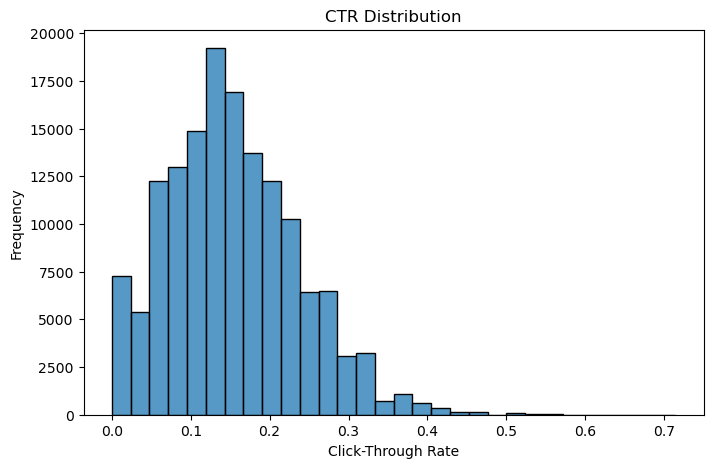

In [13]:
# Plot CTR distribution
plt.figure(figsize=(8,5))
sns.histplot(df["ctr"], bins=30)
plt.title("CTR Distribution")
plt.xlabel("Click-Through Rate")
plt.ylabel("Frequency")
plt.show()

##### 4.2. Completion Rate

This subsection analyzes the proportion of started content that was completed within a session.

In [14]:
# Calculate session-level completion rate 
df["completion_rate"] = np.where(
    df["content_started"] > 0,
    df["content_completed"] / df["content_started"],
    0
)

# Display descriptive statistics
df["completion_rate"].describe()

count    147669.000000
mean          0.556547
std           0.353322
min           0.000000
25%           0.333333
50%           0.500000
75%           1.000000
max           1.000000
Name: completion_rate, dtype: float64

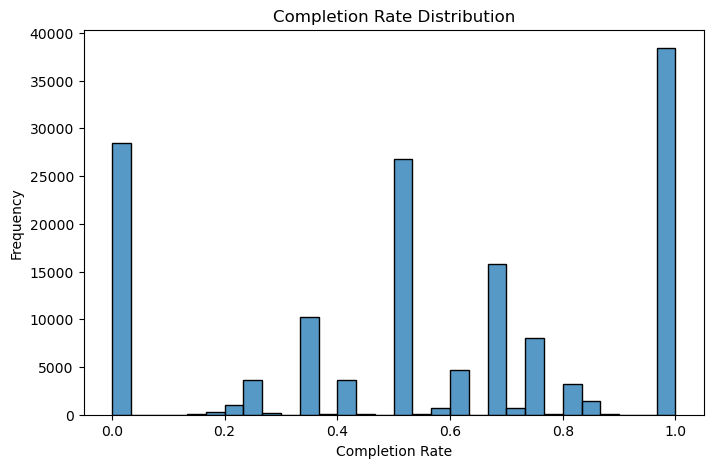

In [15]:
# Plot completion rate distribution
plt.figure(figsize=(8,5))
sns.histplot(df["completion_rate"], bins=30)
plt.title("Completion Rate Distribution")
plt.xlabel("Completion Rate")
plt.ylabel("Frequency")
plt.show()

##### 4.3. Average Minutes Watched per Session

In [16]:
# Display descriptive statistics for watch time
df["total_watch_time_minutes"].describe()

count    147669.000000
mean         39.277047
std          24.142438
min           0.390000
25%          19.240000
50%          35.360000
75%          55.800000
max         119.040000
Name: total_watch_time_minutes, dtype: float64

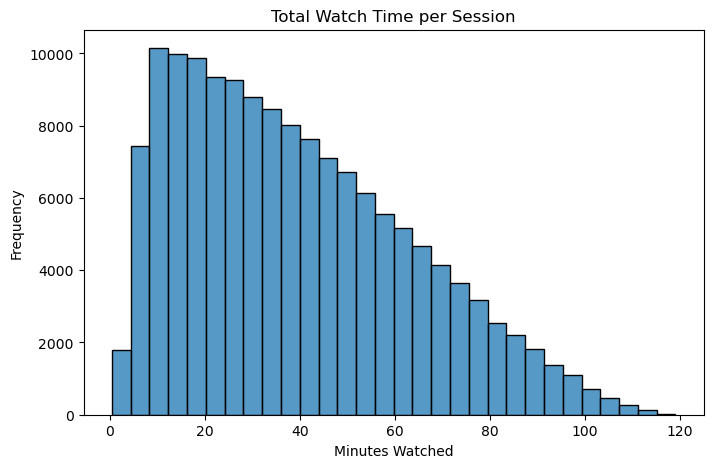

In [17]:
# Plot distribution of total watch time per session
plt.figure(figsize=(8,5))
sns.histplot(df["total_watch_time_minutes"], bins=30)
plt.title("Total Watch Time per Session")
plt.xlabel("Minutes Watched")
plt.ylabel("Frequency")
plt.show()

#### Summary of Engagement Metrics (Session-Level)

- The average CTR is approximately 15.5%, with a slightly right-skewed distribution driven by small-impression sessions.

- Completion behavior shows a discrete structure, with visible concentrations at 0%, 50%, and 100%, reflecting realistic content consumption dynamics. The average completion rate is 55.7%.

- Average watch time per session is approximately 39 minutes, with moderate dispersion and no extreme outliers.

Overall, session-level engagement metrics exhibit consistent and plausible behavior, providing a reliable foundation for group-level comparison and hypothesis testing.


#### 5. Engagement Variable Relationships

This section explores linear relationships among key engagement variables to better understand behavioral structure prior to group-level comparisons.


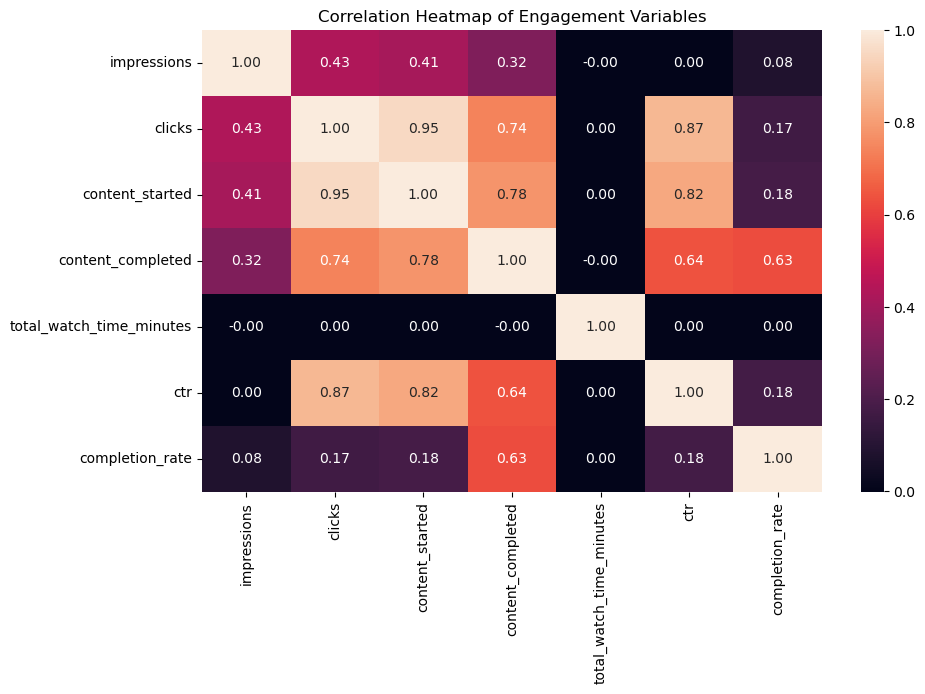

In [18]:
# Select numeric engagement variables
cols = [
    "impressions",
    "clicks",
    "content_started",
    "content_completed",
    "total_watch_time_minutes",
    "ctr",
    "completion_rate"
]

# Compute correlation matrix
corr = df[cols].corr()

# Plot heatmap
plt.figure(figsize=(10,6))
sns.heatmap(corr, annot=True, fmt=".2f")
plt.title("Correlation Heatmap of Engagement Variables")
plt.show()

#### Summary of Engagement Variable Relationships:

- Impression and click counts show moderate positive association, consistent with recommendation funnel logic.
- Content progression variables (clicks → started → completed) demonstrate hierarchical relationships.
- Watch time shows minimal linear correlation with recommendation interaction variables, consistent with the fact that total viewing behavior may originate from multiple content discovery pathways beyond recommendations.

No structurally contradictory patterns are observed.

#### 6. Group-Level Behavioral Comparison

This section compares engagement patterns between the control and treatment groups descriptively. These comparisons highlight directional differences prior to formal hypothesis testing.


##### 6.1. Structural Balance Between Groups

This subsection verifies whether user and session distributions are balanced between the control and treatment groups. Balanced exposure supports experimental validity before metric comparison.

In [19]:
# Count sessions per group
df["group"].value_counts()

group
control      73865
treatment    73804
Name: count, dtype: int64

In [20]:
# Calculate percentage difference in sessions between groups
session_counts = df["group"].value_counts()
pct_diff_sessions = (session_counts.max() - session_counts.min()) / session_counts.mean() * 100

print(f"Percentage difference in sessions between groups: {pct_diff_sessions:.2f}%")

Percentage difference in sessions between groups: 0.08%


In [21]:
# Count unique users per group
user_counts = df.groupby("group", observed=True)["user_id"].nunique()
user_counts

group
control      12185
treatment    12310
Name: user_id, dtype: int64

In [22]:
# Calculate percentage difference in users
pct_diff_users = (user_counts.max() - user_counts.min()) / user_counts.mean() * 100
print(f"Percentage difference in unique users between groups: {pct_diff_users:.2f}%")

Percentage difference in unique users between groups: 1.02%


##### 6.2. Click-Through Rate (CTR) by Group

This subsection compares average session-level CTR between control and treatment groups to identify directional differences prior to formal hypothesis testing.

In [23]:
# Calculate mean CTR per group
ctr_by_group = df.groupby("group", observed=False)["ctr"].mean()

print("Average CTR by group:")
print(ctr_by_group)

Average CTR by group:
group
control      0.150257
treatment    0.160102
Name: ctr, dtype: float64


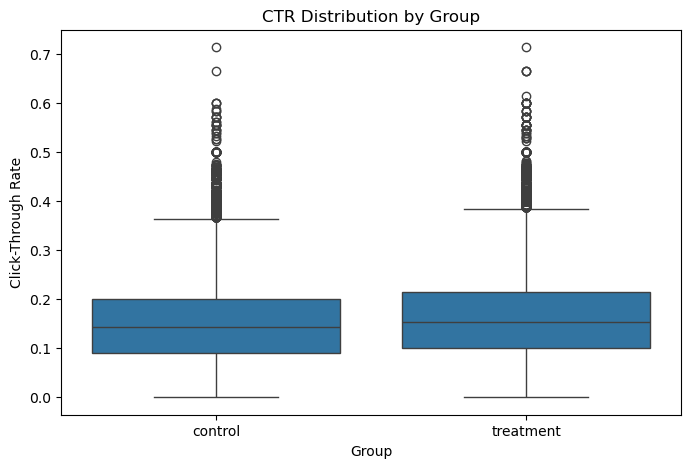

In [24]:
# Visualize CTR distribution by group
plt.figure(figsize=(8,5))
sns.boxplot(x="group", y="ctr", data=df)

plt.title("CTR Distribution by Group")
plt.xlabel("Group")
plt.ylabel("Click-Through Rate")
plt.show()

##### 6.3. Completion Rate by Group

This subsection compares average session-level completion rates between control and treatment groups to assess directional differences in content consumption behavior.

In [25]:
# Calculate mean completion rate per group
completion_by_group = df.groupby("group", observed=False)["completion_rate"].mean()

print("Average Completion Rate by group:")
print(completion_by_group)

Average Completion Rate by group:
group
control      0.557201
treatment    0.555891
Name: completion_rate, dtype: float64


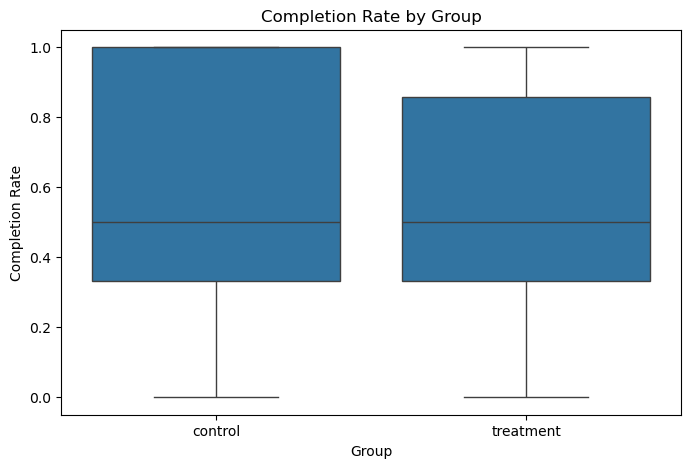

In [26]:
# Visualize completion rate distribution by group
plt.figure(figsize=(8,5))
sns.boxplot(x="group", y="completion_rate", data=df)

plt.title("Completion Rate by Group")
plt.xlabel("Group")
plt.ylabel("Completion Rate")
plt.show()

##### 6.4. Average Minutes Watched per Session by Group

This subsection compares average session-level watch time between control and treatment groups to assess potential differences in overall content consumption intensity.

In [27]:
# Calculate mean watch time per group
watch_time_by_group = df.groupby("group", observed=False)["total_watch_time_minutes"].mean()

print("Average Minutes Watched per Session by group:")
print(watch_time_by_group)

Average Minutes Watched per Session by group:
group
control      38.966899
treatment    39.587450
Name: total_watch_time_minutes, dtype: float64


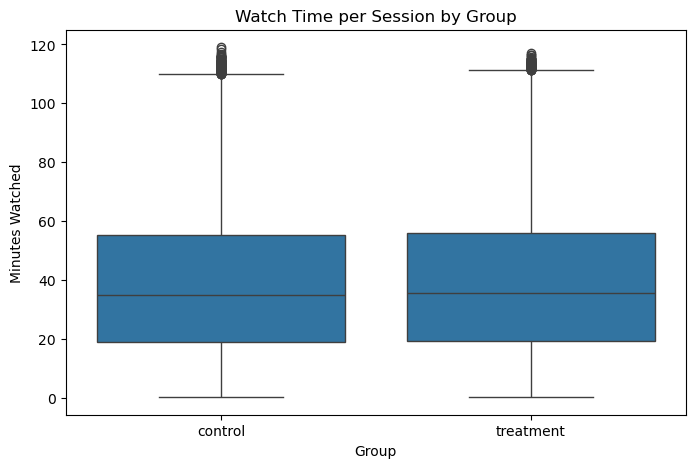

In [28]:
# Visualize watch time distribution by group
plt.figure(figsize=(8,5))
sns.boxplot(x="group", y="total_watch_time_minutes", data=df)

plt.title("Watch Time per Session by Group")
plt.xlabel("Group")
plt.ylabel("Minutes Watched")
plt.show()

#### Summary of Group-Level Behavioral Comparison

- Post-cleaning structural validation confirms that both groups remain well balanced, with session and user distributions differing by 0.08% and 1.02%, supporting experimental integrity.

- Descriptive comparison of engagement metrics indicates that the treatment group exhibits a slightly higher average CTR (16.01% vs. 15.03%) and average watch time per session (+0.62 minutes).

- Completion rates are nearly identical across groups (55.72% vs. 55.59%), with a minimal difference of 0.13 percentage points favoring the control group.

Overall, directional differences favor the treatment group for short-term engagement metrics, while content completion behavior remains largely unchanged. Formal hypothesis testing is required to determine whether these observed differences are statistically significant.


#### 7. User-Level Comparison of Primary Metrics

##### 7.1. User-Level Aggregation

This subsection aggregates session-level data to the user level in preparation for calculating user-based metrics, including return behavior and user-level CTR.


In [29]:
# Aggregate session data to user level
user_df = df.groupby("user_id", observed=False).agg(
    group=("group", "first"),
    total_sessions=("session_id", "count"),
    total_impressions=("impressions", "sum"),
    total_clicks=("clicks", "sum"),
    first_session=("session_start", "min"),
    last_session=("session_start", "max")
).reset_index()

# Sort user-level dataframe by numeric user_id for clearer display
user_df = user_df.sort_values(by="user_id", key=lambda x: x.astype(int)).reset_index(drop=True)

# Display first five rows
user_df.head()   

,user_id,group,total_sessions,total_impressions,total_clicks,first_session,last_session
0,1,control,6,107,12,2026-01-03 11:13:01.347082148,2026-01-17 00:53:36.354677162
1,2,treatment,8,176,32,2026-01-05 14:57:54.261910656,2026-01-20 14:18:51.515044869
2,3,treatment,11,234,33,2026-01-03 05:22:32.449521299,2026-01-20 16:54:14.307980693
3,4,treatment,5,86,9,2026-01-04 18:47:58.126068735,2026-01-17 18:57:46.818191863
4,5,control,8,153,30,2026-01-03 00:23:39.830004774,2026-01-21 03:45:08.749071724


##### 7.2. User-Level Click-Through Rate (CTR)

This subsection calculates CTR at the user level by aggregating total clicks and total impressions per user. User-level CTR is required for hypothesis testing, as the unit of analysis for the experiment is the user rather than individual sessions.

Session-level CTR is useful for exploration, but user-level CTR is required for valid inference because the experiment is randomized at the user level.

In [30]:
# Calculate user-level CTR
user_df["user_ctr"] = np.where(
    user_df["total_impressions"] > 0,
    user_df["total_clicks"] / user_df["total_impressions"],
    0
)

# Display descriptive statistics
user_df["user_ctr"].describe()

count    24495.000000
mean         0.155004
std          0.038172
min          0.000000
25%          0.130682
50%          0.153846
75%          0.177914
max          0.476190
Name: user_ctr, dtype: float64

In [31]:
# Compare user-level CTR by group
user_ctr_by_group = user_df.groupby("group", observed=False)["user_ctr"].mean()

print("User-level CTR by group:")
print(user_ctr_by_group)

User-level CTR by group:
group
control      0.150297
treatment    0.159662
Name: user_ctr, dtype: float64


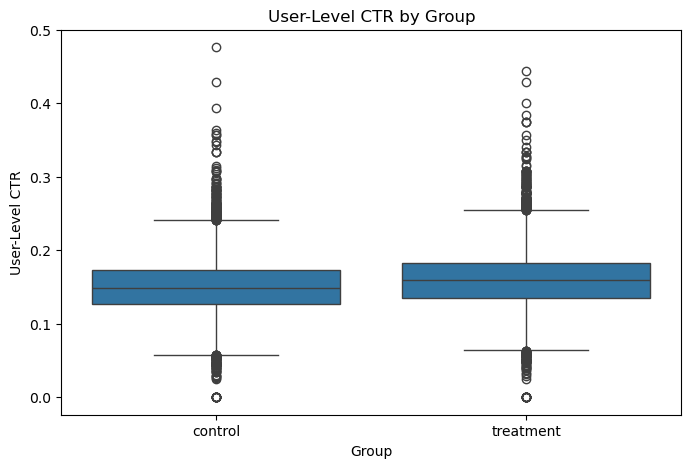

In [32]:
# Visualize user-level CTR by group
plt.figure(figsize=(8,5))
sns.boxplot(x="group", y="user_ctr", data=user_df)

plt.title("User-Level CTR by Group")
plt.xlabel("Group")
plt.ylabel("User-Level CTR")
plt.show()

##### 7.3. 7-Day Return Rate

This subsection constructs the 7-day return indicator at the user level. A user is considered to have returned if at least one subsequent session occurs within 7 days of their first session during the experiment period.


In [33]:
# Sort by user and session_start to ensure chronological order
df_sorted = df.sort_values(["user_id", "session_start"])

# Identify first session per user
first_sessions = df_sorted.groupby("user_id", observed=False)["session_start"].first()

# Merge first session back to full dataset
df_sorted = df_sorted.merge(
    first_sessions.rename("first_session"),
    on="user_id"
)

# Calculate days since first session
df_sorted["days_since_first"] = (
    df_sorted["session_start"] - df_sorted["first_session"]
).dt.days

# Identify whether user has any session within 1–7 days after first
return_flag = (
    df_sorted[
        (df_sorted["days_since_first"] > 0) &
        (df_sorted["days_since_first"] <= 7)
    ]
    .groupby("user_id", observed=False)
    .size()
    .gt(0)
    .astype(int)
)

# Add return flag to user-level dataset
user_df = user_df.merge(
    return_flag.rename("returned_within_7_days"),
    on="user_id",
    how="left"
)

# Fill users with no return as 0
user_df["returned_within_7_days"] = user_df["returned_within_7_days"].fillna(0).astype(int)

# Check return rate distribution
user_df["returned_within_7_days"].value_counts()

returned_within_7_days
1    21010
0     3485
Name: count, dtype: int64

In [34]:
# Calculate return rate by group
return_rate_by_group = user_df.groupby("group", observed=False)["returned_within_7_days"].mean()

print("7-Day Return Rate by group:")
print(return_rate_by_group)

7-Day Return Rate by group:
group
control      0.855724
treatment    0.859708
Name: returned_within_7_days, dtype: float64


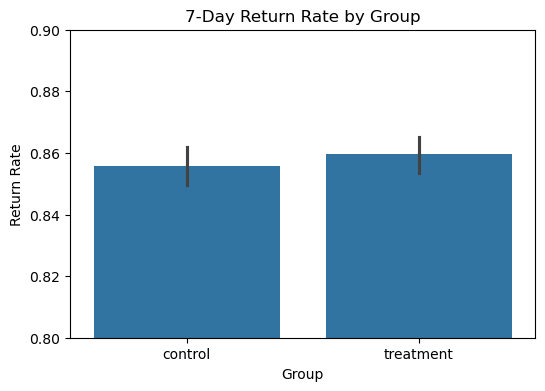

In [35]:
# Visualize return rate by group
plt.figure(figsize=(6,4))
sns.barplot(x="group", y="returned_within_7_days", data=user_df)

plt.title("7-Day Return Rate by Group")
plt.ylabel("Return Rate")
plt.xlabel("Group")
plt.ylim(0.8, 0.9)
plt.show()

##### Summary of User-Level Aggregation and Return Behavior

User-level aggregation confirms that engagement patterns remain consistent when evaluated at the correct experimental unit. 

- Average user-level CTR is approximately 15.5%, with the treatment group exhibiting a modest directional increase compared to control.

- The 7-day return rate is high across both groups (~86%), indicating strong short-term retention during the experiment period. The treatment group shows a slight improvement of approximately 0.4 percentage points in return behavior.

Overall, user-level metrics indicate small directional improvements in short-term engagement for the treatment group. Formal hypothesis testing is required to determine whether these differences are statistically significant.